In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import os, sys, shutil, copy, time
from torch.utils.data import Dataset, DataLoader
from dataset import *

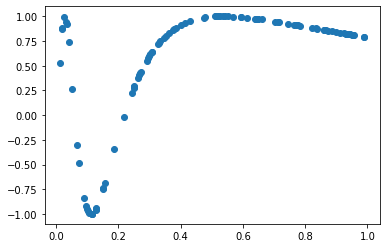

In [6]:
dataset = ToyDataset()
    
x, y = dataset[:]

plt.scatter(x.flatten(), y.flatten())
plt.show()

In [7]:
train = True
df = pd.concat([pd.read_csv('CreditScore_train.csv'), pd.read_csv('CreditScore_test.csv')])


In [8]:
df.shape

(100000, 305)

In [9]:
#missing data

percent = (df.isnull().sum() / df.isnull().count() * 100)
m_per = percent[percent > 10]
df = df.drop(columns=m_per.index, axis=1)

for i in df.columns:
    df[i].fillna(df[i].mean(), inplace=True)
print(df.shape)

(100000, 266)


In [10]:
df.describe()

,x001,x005,x006,x007,x008,x009,x010,x011,x012,x013,...,x291,x292,x294,x296,x298,x299,x300,x301,x303,y
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.218244e+06,178.238545,0.314040,0.694000,1.388220,1.192980,1.026990,1.843240,1.60794,1.576860,...,1.461510e+04,5.839332e+04,2.795508e+03,1.181960e+04,0.543320,0.558030,0.581830,0.106240,6410.882910,619.198230
std,2.728977e+05,120.656530,0.464135,1.379378,2.282805,2.031083,1.713823,2.711524,2.58239,2.609533,...,3.771714e+04,1.645305e+05,1.751578e+04,3.226469e+04,0.498122,0.496624,0.493261,0.308146,24190.243313,118.461932
min,5.170000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000
25%,9.743635e+05,94.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,524.000000
50%,1.235926e+06,159.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000,...,0.000000e+00,4.758000e+03,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,599.000000
75%,1.445326e+06,237.000000,1.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.00000,2.000000,...,1.712800e+04,4.333125e+04,0.000000e+00,1.295600e+04,1.000000,1.000000,1.000000,0.000000,0.000000,720.000000
max,1.677197e+06,827.000000,1.000000,44.000000,108.000000,81.000000,33.000000,44.000000,44.00000,42.000000,...,4.348891e+06,1.520793e+07,3.721366e+06,2.696702e+06,1.000000,1.000000,1.000000,1.000000,785537.000000,839.000000


In [11]:
if train:
    df = df.iloc[:80000]
else:
    df = df.iloc[80000:]


In [12]:
x_data = df.drop("y", axis=1).to_numpy()
y_data = df["y"].to_numpy()

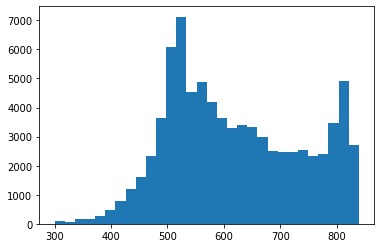

In [20]:
plt.hist(y_data, bins=30)
plt.show()

In [13]:
print(x_data.shape, y_data.shape)

(80000, 265) (80000,)


In [19]:
np.argsort(np.argsort(x_data, axis=0), axis=0) / x_data.shape[0]

array([[0.316725 , 0.9537625, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.5584125, 0.502    , 0.6964875, ..., 0.754175 , 0.6283   ,
        0.769825 ],
       [0.795025 , 0.7537125, 0.656675 , ..., 0.3804625, 0.6282875,
        0.770525 ],
       ...,
       [0.4231875, 0.416575 , 0.2716125, ..., 0.437275 , 0.314625 ,
        0.30005  ],
       [0.5813375, 0.9175125, 0.19915  , ..., 0.8595   , 0.1638625,
        0.116075 ],
       [0.0058625, 0.29575  , 0.4073375, ..., 0.9999875, 0.8210125,
        0.954725 ]])

In [2]:
dataset = CreditDataset(train=True)

(array([[1.084094e+06, 4.260000e+02, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.287777e+06, 1.600000e+02, 1.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.483016e+06, 2.390000e+02, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.168324e+06, 1.350000e+02, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.307105e+06, 3.660000e+02, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [4.051600e+05, 1.090000e+02, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 4.445100e+04]]), array([[807],
       [819],
       [803],
       ...,
       [711],
       [684],
       [465]]))
